
# ROOM OCCUPANCY PROJECT

This is a simple project aiming at estimating the occupancy (count) of a room using data recorded by different sensors (temperature, CO2, sound, light and motion) as a function of time.  
Data are based on a [paper published in IEEE](https://ieeexplore.ieee.org/document/8644432) and can be found on [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation).

We will first attempt to reproduce the results presented in the paper, then we will try to improve the results using feature engineering and by building more complex models.

## Imports

In [377]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()

from room_occupancy_module import (read_file_df,plot_columns_index_occupancy,plot_onecolumn_index_occupancy,
                                   plot_one_columns_index_occupancy_compare_transformation,plot_confusion_acc_f1)
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [378]:
# preprocessing
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import GridSearchCV,cross_val_predict,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Data Collection

Save data from URL to dataframe `df`.

In [391]:
file_path = 'https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip'
df = read_file_df(file_path)

In [392]:
df.head(1)

,date,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1


In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  10129 non-null  datetime64[ns]
 1   S1_Temp               10129 non-null  float64       
 2   S2_Temp               10129 non-null  float64       
 3   S3_Temp               10129 non-null  float64       
 4   S4_Temp               10129 non-null  float64       
 5   S1_Light              10129 non-null  int64         
 6   S2_Light              10129 non-null  int64         
 7   S3_Light              10129 non-null  int64         
 8   S4_Light              10129 non-null  int64         
 9   S1_Sound              10129 non-null  float64       
 10  S2_Sound              10129 non-null  float64       
 11  S3_Sound              10129 non-null  float64       
 12  S4_Sound              10129 non-null  float64       
 13  S5_CO2          

All features are numerical and target `Room_Occupacy_Count` is multi-class (int from 0 to 4).

In [394]:
df['Room_Occupancy_Count'].value_counts()

Room_Occupancy_Count
0    8228
2     748
3     694
1     459
Name: count, dtype: int64

Classes are unbalanced, we will need to use stratification and rely on F1-score in the validation process.

In [395]:
df.isnull().sum()

date                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

No missing data in the dataset, they were removed beforehand by the authors.

### Target Column

Let's take a loot at the target columns `Room_Occupancy_Count` as a function of time and as of function of the index.

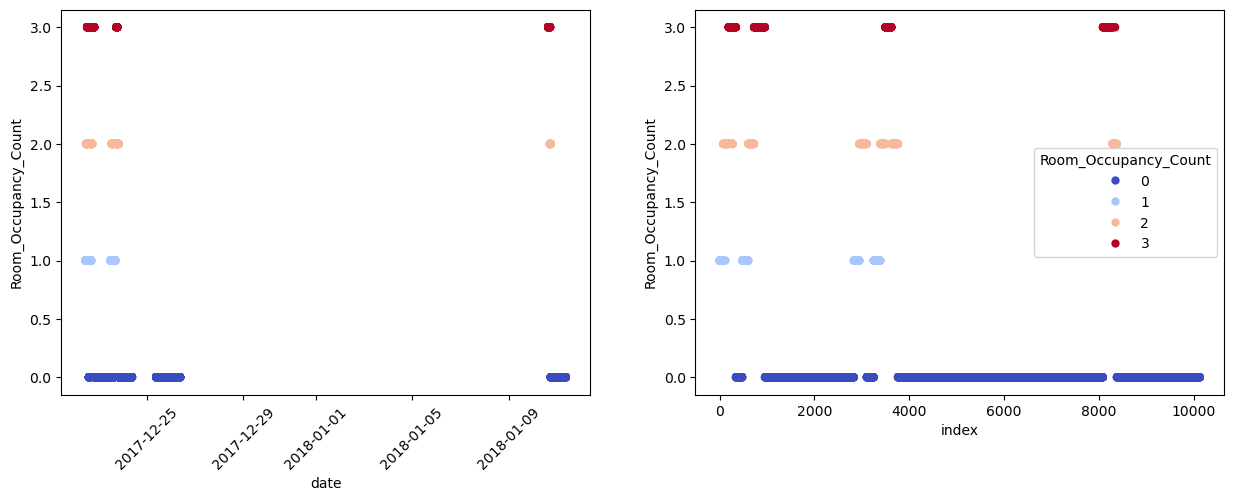

In [397]:
fig,axs = plt.subplots(1,2,figsize = (15,5))
sns.scatterplot(ax=axs[0],data = df, X_base='date', y='Room_Occupancy_Count', hue = 'Room_Occupancy_Count', palette='coolwarm', edgecolor="none",legend = False)
sns.scatterplot(ax=axs[1],data = df, X_base=df.index, y='Room_Occupancy_Count', hue = 'Room_Occupancy_Count', palette='coolwarm', edgecolor="none",legend = True)
axs[1].set_xlabel('index')
axs[0].tick_params(axis="X_base",labelrotation=45);

There is large time gap between two experiments, one carried out in 2017 and the other in 2018. Looking at features *vs* index will be more useful. Since our goal here is not to forecast the occupancy count but to predict its value at a given time, we can safely drop the `date` column.

In [398]:
df= df.drop(columns='date')

## Previous Results

Before attempting to improve the model described in the paper, we will try to reproduce the presented results. To get the best accuracy and f1 score combo, the authors used a SVC with the rbf kernel. They write:  "*Metrics such as accuracy, F1 score and confusion matrix were evaluated using 10-fold cross validation. Since the data is of time-series nature, data was not shuffled prior to cross validation to avoid data points similar to test data getting into the training data*". Macro average was use to compute f1-score. This seems to correspond to what one would get from `cross_val_predict` to find a metric on the whole dataset. 

In [422]:
X_base = df.copy()
y = X_base.pop('Room_Occupancy_Count')

In [423]:
X_base.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')

The study does not report the optimal parameters for the SVC classifier, we'll use `GridSearchCV` to figure them out. Cross valitation is set to default `cv=10`, which is 10-fold stratififed cross validation without shuffling.

In [424]:
svc_pipeline_1 = Pipeline([
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC())

])

# best parameters
svc_param_grid_1 = [{
'svc_rbf__C':[10],
'svc_rbf__gamma':[0.001]
}]

# for gridsearch
# svc_param_grid_1 = [{
# 'svc_rbf__C':[1,10,100],
# 'svc_rbf__gamma':[0.01,0.001,0.0001]
# }]

svc_grid_1 = GridSearchCV(svc_pipeline_1, svc_param_grid_1, scoring='f1_macro', cv=10, n_jobs=-1)
svc_grid_1.fit(X_base, y)

std_svc_best_1 = svc_grid_1.best_estimator_
std_svc_best_1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=10, gamma=0.001))])

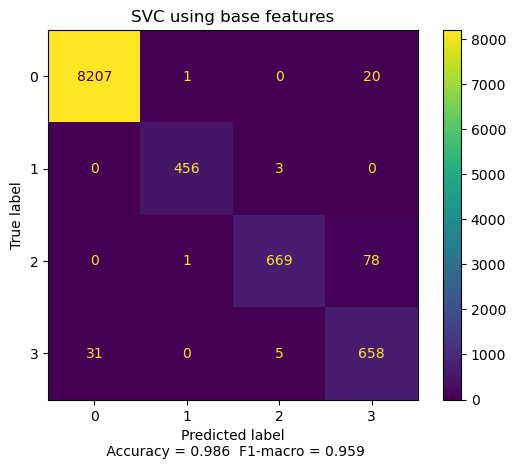

In [403]:
svc_predictions_1 = cross_val_predict(std_svc_best_1,X_base,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,svc_predictions_1,'SVC using base features')

The best model is obtained for $C=10$ and $\gamma = 0.001$, which provides an accuracy of 0.986 and f1_macro score of 0.959. These results are extremely close to the 0.984 accuracy and 0.953 macro f1-score reported in the paper.

## Data Exploration and Feature Engineering

Now, we will attempt to improve the model's accuracy and f1 score by:
- Enhancing feature engineering
- Tweaking the model

Let's first take a close look at the features

In [404]:
X_base.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')

Features can be grouped by sensor types : temperature, light, sound, CO2 level and infrared (PIR). We group the columns names by type: `temp_features`,  `light_features`, `sound_features`,`CO2_features` and `PIR_features` for easy access.

In [430]:
temp_features = ['S1_Temp','S2_Temp','S3_Temp','S4_Temp']
light_features = ['S1_Light','S2_Light','S3_Light','S4_Light']
sound_features = ['S1_Sound','S2_Sound','S3_Sound','S4_Sound']
CO2_features = ['S5_CO2','S5_CO2_Slope']
PIR_features = ['S6_PIR','S7_PIR']

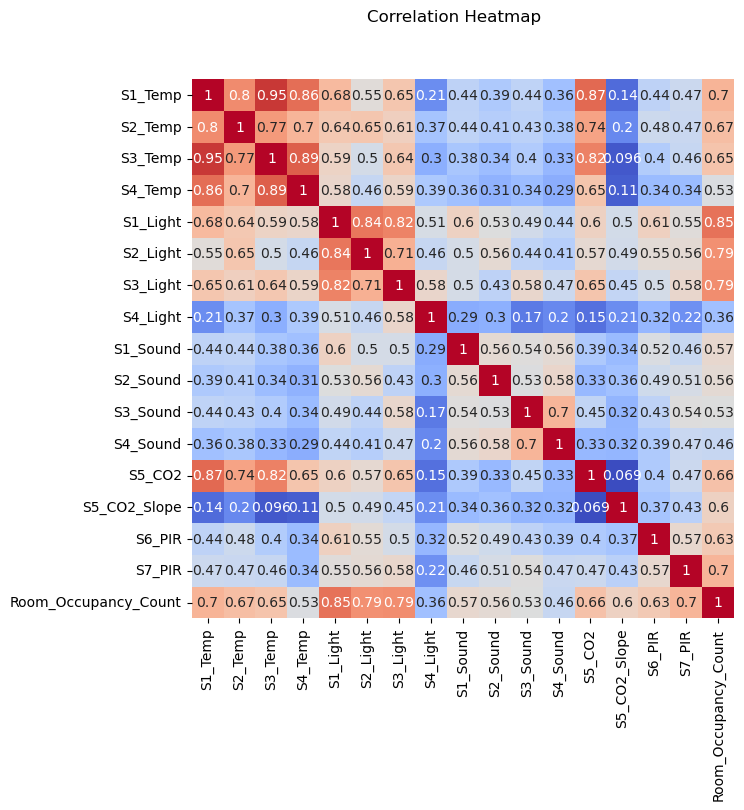

In [418]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
sns.heatmap(df.corr(), ax=ax, cbar=False, cmap='coolwarm', annot=True)
fig.suptitle('Correlation Heatmap');

Without too much surprise, the sensors response for the same sensor types are highly correlated. It could make sense to use the average sensor response instead of each indivudal sensor response.

### Temperature features

Let's look at the evolution of the signal from the temperature sensors.

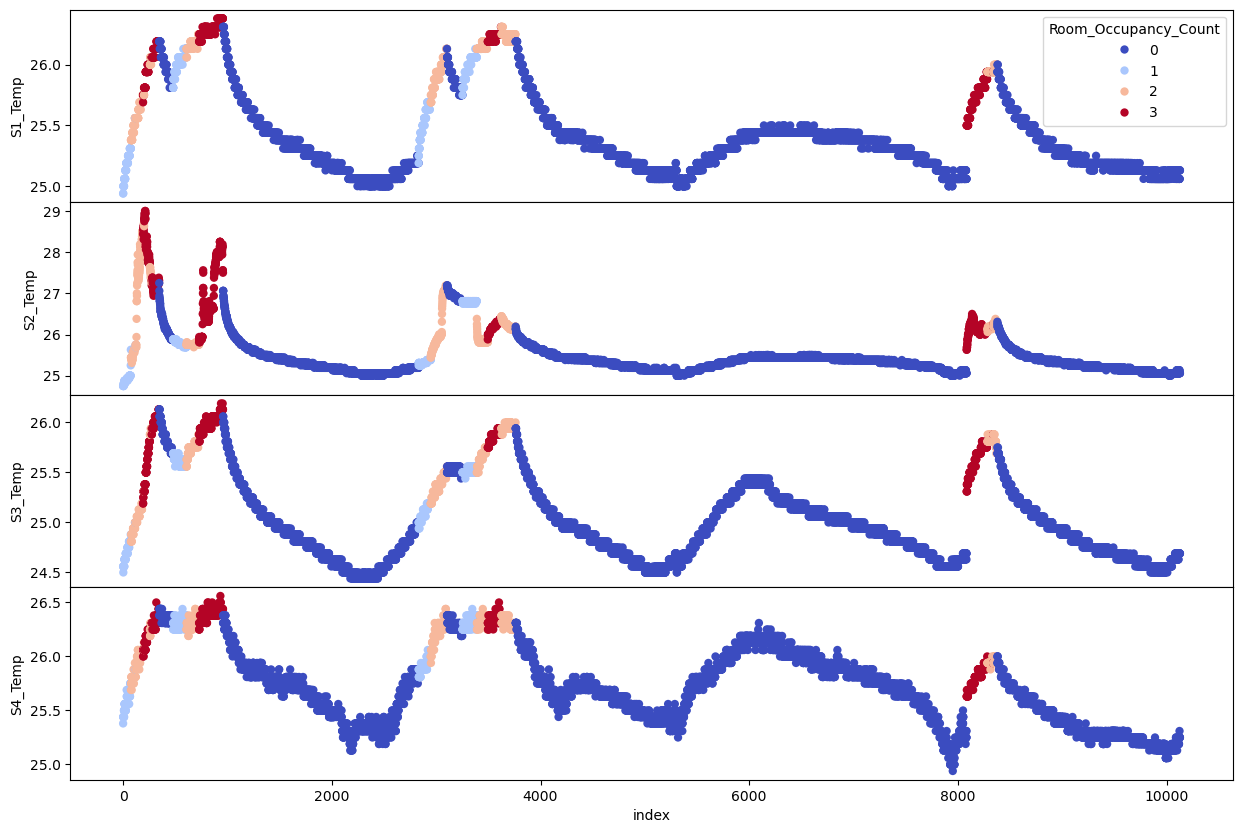

In [419]:
plot_columns_index_occupancy(df,temp_features)

It looks like occupancy has an impact on the rate of change of the temperature, but the overal response depends a lot on history. Maybe the average temperature over the four sensors could be interesting to look at.

We create a new dataframe `df_avg` for the new features we will add: the average sensor response for each sensor type.

In [433]:
df_avg = df[['Room_Occupancy_Count']].copy()

Adding a column `avg_temp` representing the average temperature of the four sensors.

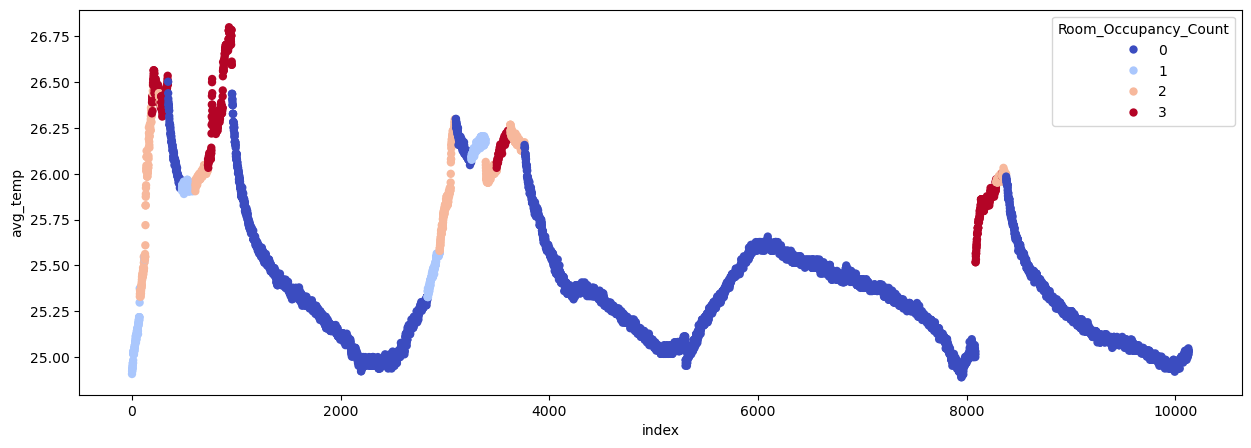

In [434]:
df_avg['avg_temp'] = df[temp_features].mean(axis=1)
plot_onecolumn_index_occupancy(df_avg,'avg_temp')

### Light features

We do the same for the lights sensors.

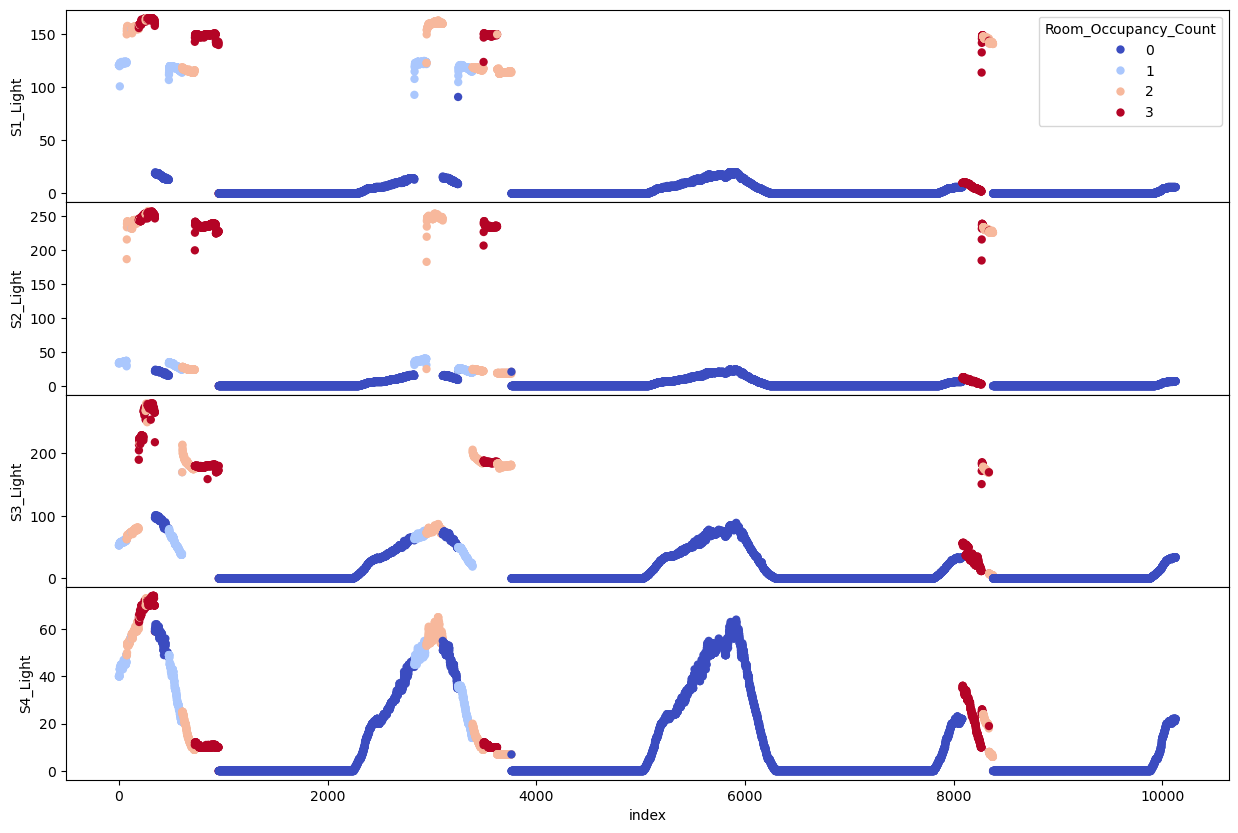

In [435]:
plot_columns_index_occupancy(df,light_features)

Adding a column `avg_light` representing the average light of the four sensors.

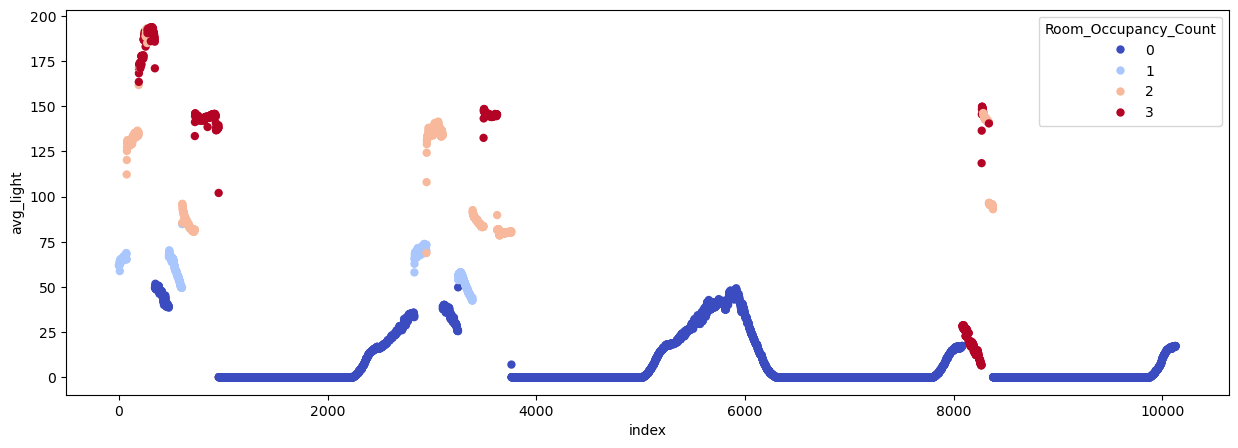

In [436]:
df_avg['avg_light'] = df[light_features].mean(axis=1)
plot_onecolumn_index_occupancy(df_avg,'avg_light')

Looking at `avg_light`, we can roughly determine the room occupancy by setting threshold values of 50, 100 and 150. This feature will probably help classification.

### Sound Features

Now for the sound features.

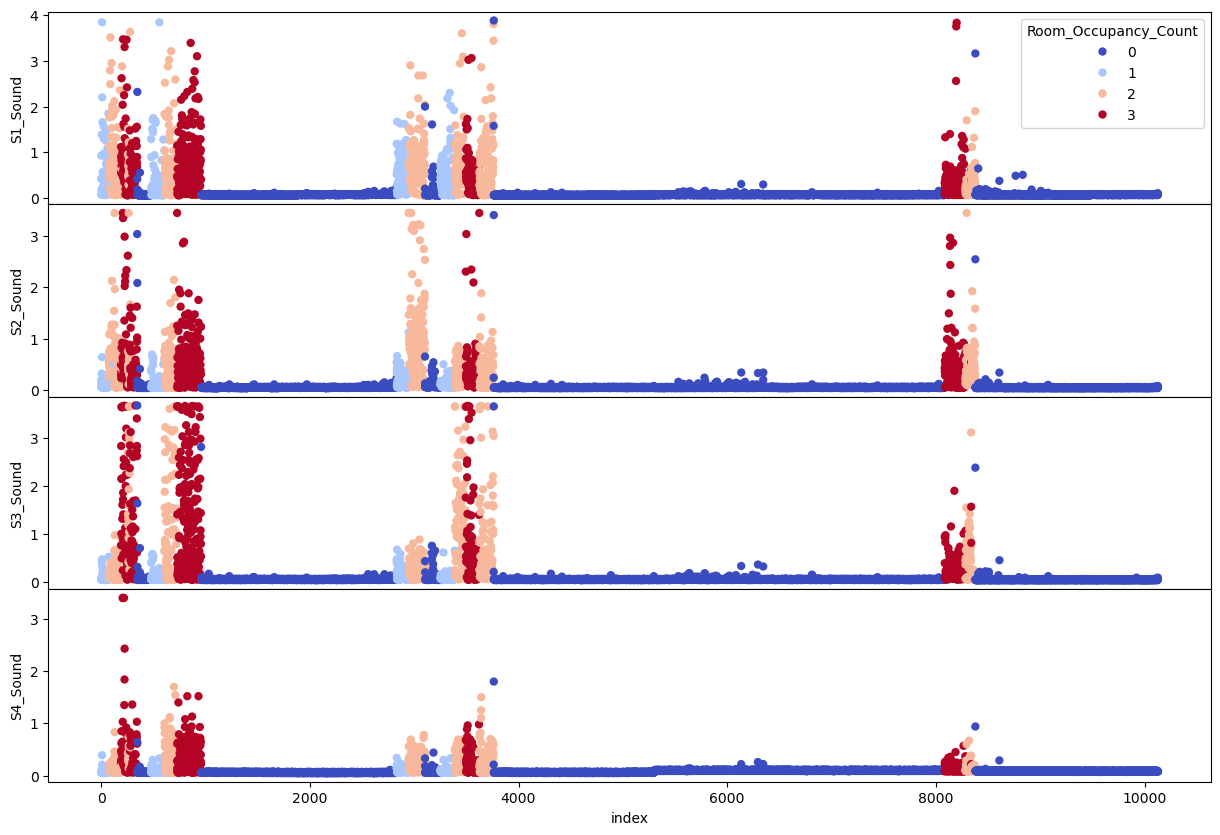

In [437]:
plot_columns_index_occupancy(df,sound_features)

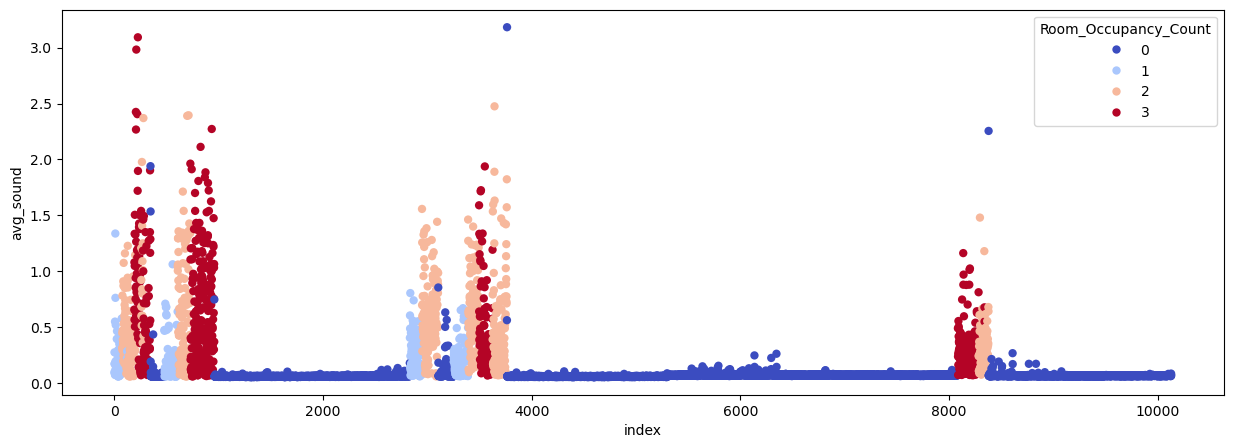

In [438]:
df_avg['avg_sound'] = df[sound_features].mean(axis=1)
plot_onecolumn_index_occupancy(df_avg,'avg_sound')

### CO2 features

The CO2 slope was extracted using a 25-points sliding window. Since the signal from other sensors can be quite noisy, ***it may be a good idea to also implement a sliding window average*** to smooth the other sensors response as well. We will need to implement it through a sk-learn transformer later to prevent data leakage from the sliding window.

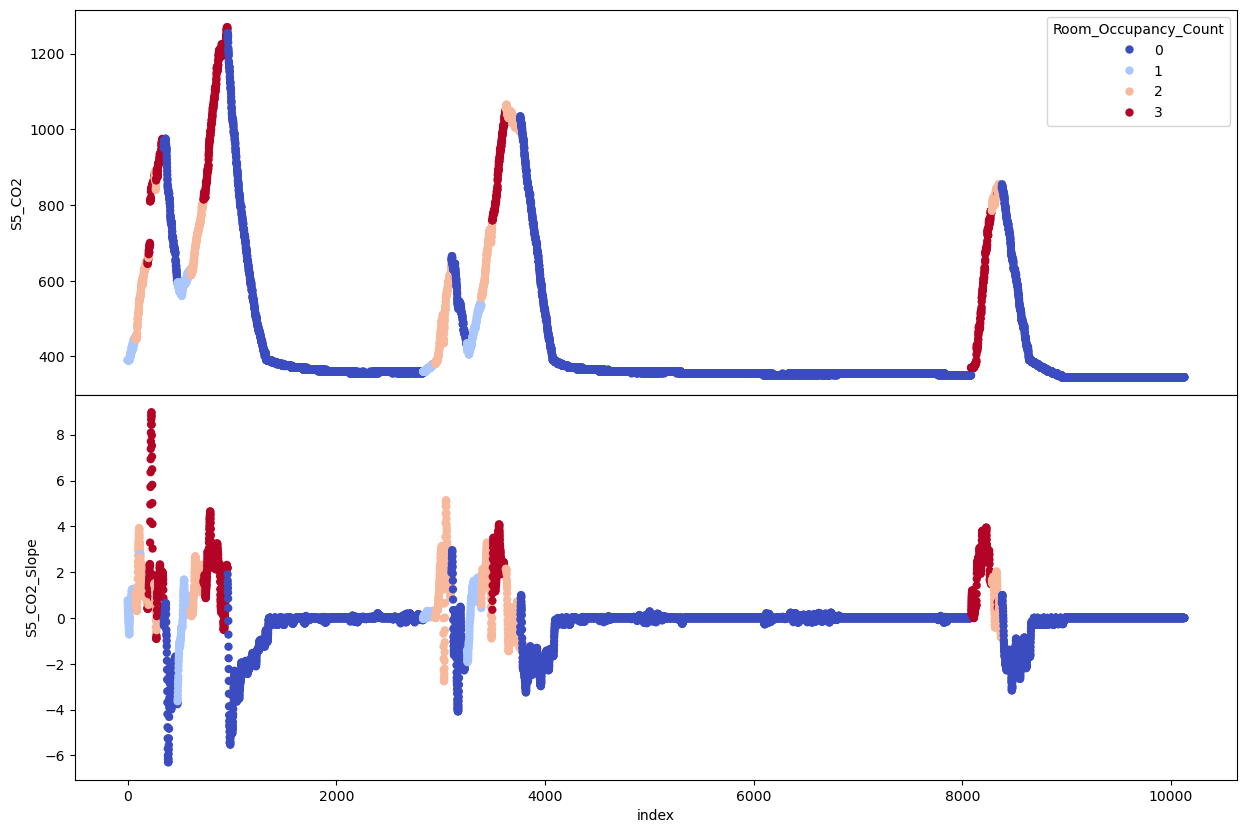

In [439]:
plot_columns_index_occupancy(df,CO2_features)

There are no multiple CO2 sensor signals we can average in this case.

### PIR Features

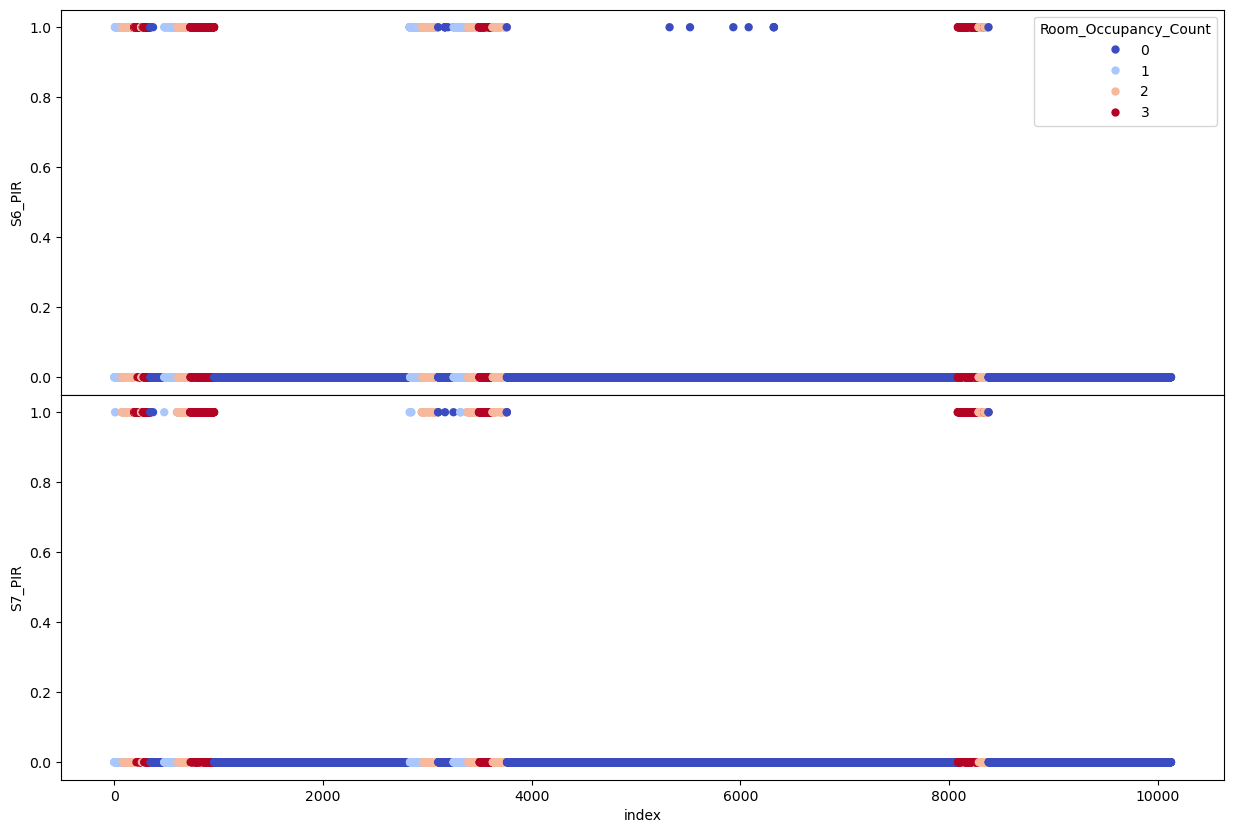

In [440]:
plot_columns_index_occupancy(df,PIR_features)

If we zoom in to see the indices below 1000, we see that the PIR signal fluctuates a lot when the occupancy is non zero. Using an rolling average would probably yield better prediction power for this feature.

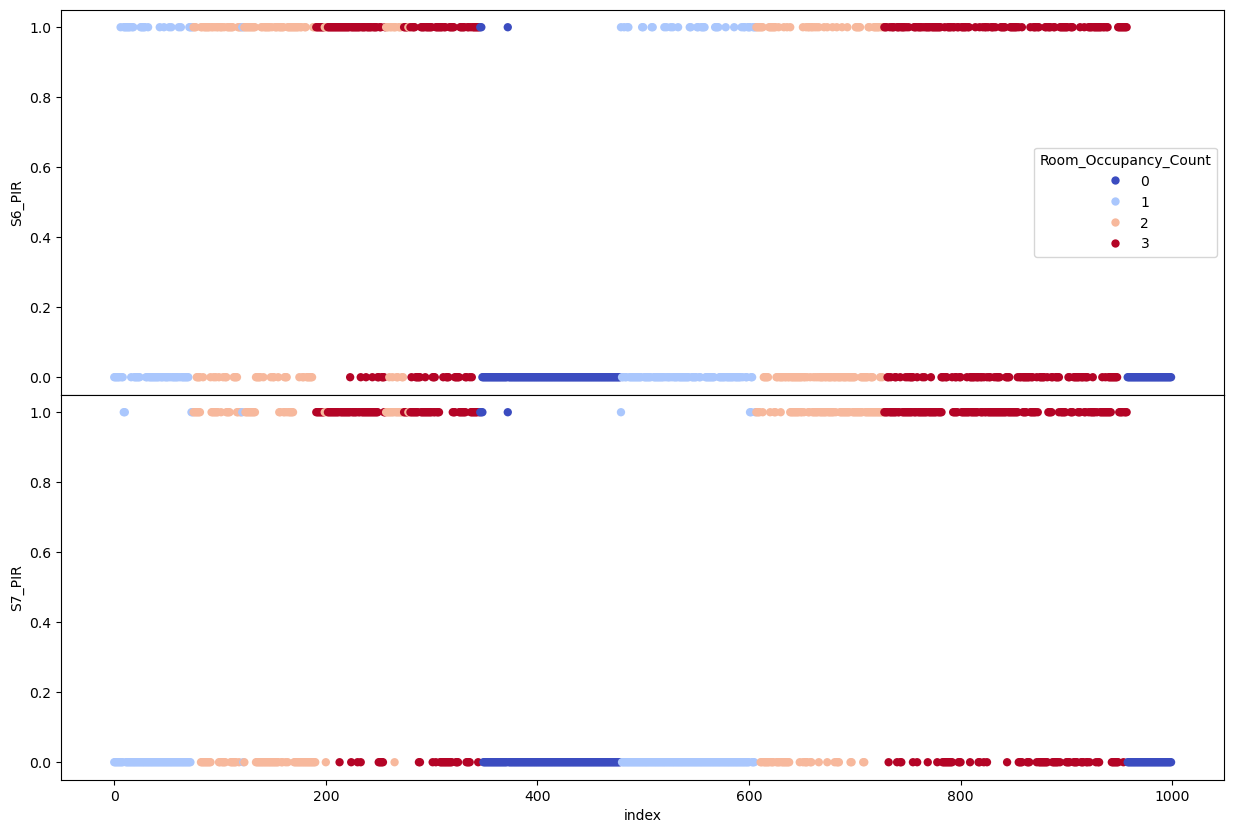

In [441]:
plot_columns_index_occupancy(df.query('index<1000'),PIR_features)

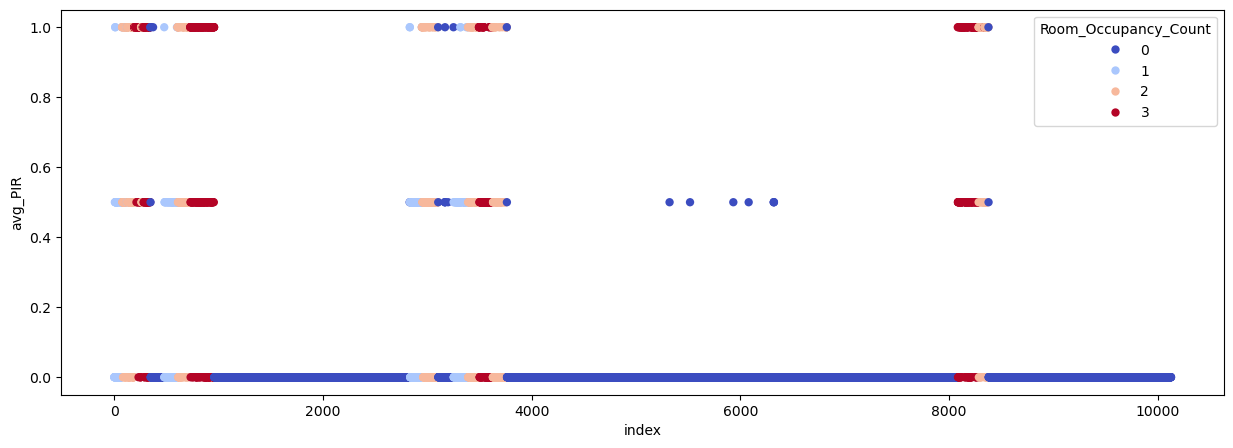

In [442]:
df_avg['avg_PIR'] = df[PIR_features].mean(axis=1)
plot_onecolumn_index_occupancy(df_avg,'avg_PIR')

### Averaging window

We'll quickly see if using an averaging windows yields significantly different response. This will also impact the target, but we will take car of that during the prober model evaluation. We'll use the `Window_Average` transformer with a width of 25 points, as for the comutation of `CO2_Slope`.

In [444]:
from transformers import Window_Average

In [445]:
averager = Window_Average(25)

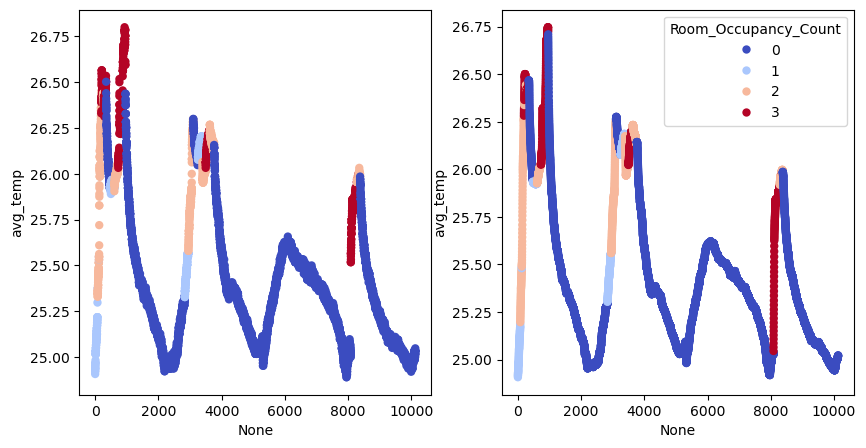

In [447]:
plot_one_columns_index_occupancy_compare_transformation(df_avg,'avg_temp',averager)

Left plot shows raw data, right plot shows averaged results. There is no significant difference between the average temperature and its window-averaged counterpart. It makes sens since this variable changes smoothly over time.

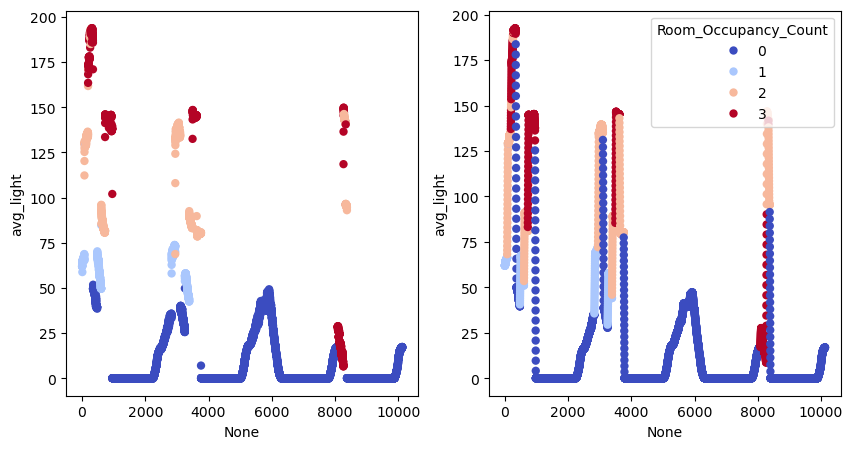

In [131]:
plot_one_columns_index_occupancy_compare_transformation(df_avg,'avg_light',averager)

Class separation seems to be worse when adding the window average for light feature.

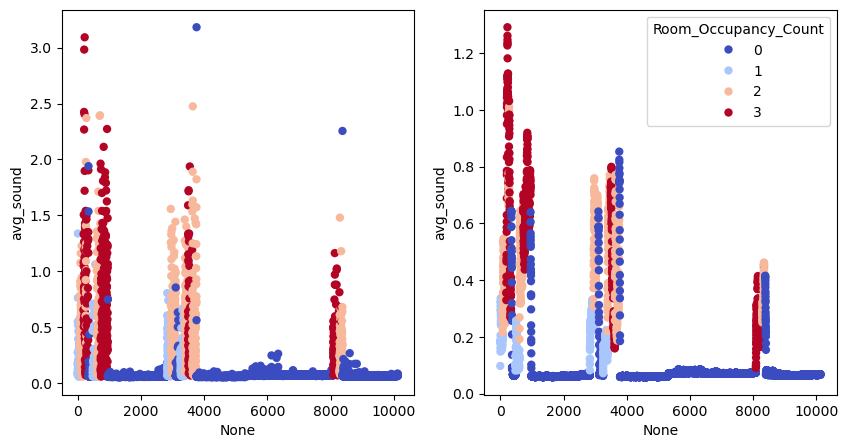

In [448]:
plot_one_columns_index_occupancy_compare_transformation(X_avg,'avg_sound',averager)

Class separation also seems worse when adding the window average for sound feature.

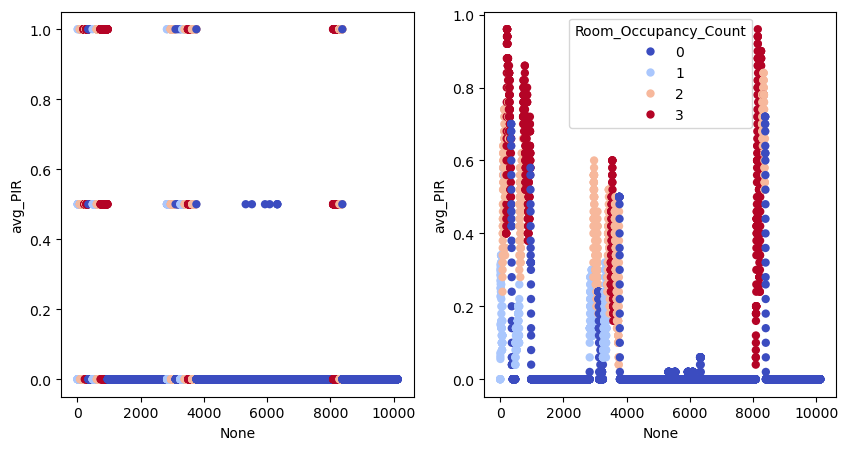

In [449]:
plot_one_columns_index_occupancy_compare_transformation(X_avg,'avg_PIR',averager)

Class separation looks better when adding the window average to the PIR feature.

### Base + Sensor Average

We'll see if the base model performs better with the new features (column averages), then we'll try to add the window-averaged features.

In [452]:
X_base_avg = pd.concat([X_base,df_avg.drop(columns='Room_Occupancy_Count')],axis=1)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


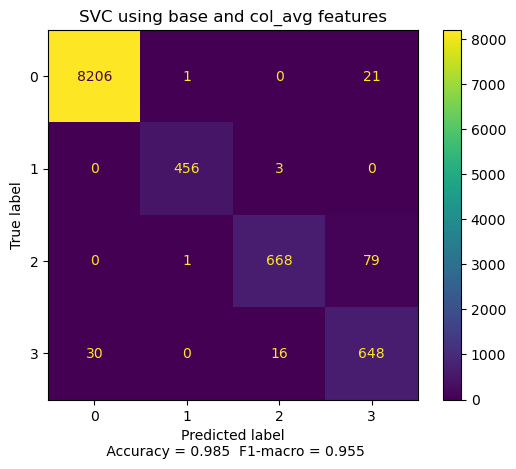

In [453]:
svc_predictions_2 = cross_val_predict(std_svc_best_1, X_base_avg, y, cv=10, n_jobs=-1)
plot_confusion_acc_f1(y,svc_predictions_2,'SVC using base and col_avg features')

Performances are essentially unchanged. It seems that the column average are not usefull.

### Base +  Window-averaged Average PIR

We'll add the window-averaged average PIR response as it seemed to yield better classe separation.

In [455]:
X_avg_PIR = pd.concat([X_base,df_avg['avg_PIR']],axis=1)

Window averaging is implemented in the model pipeline to prevent data leakage from test to train set through the slidding window. We will test three values for the window size : 1, 25 and 50 data points.

In [470]:
svc_pipeline_2 = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average(25),['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC(C=10,gamma=0.01))
])

svc_param_grid_2 = [{

'averager__avg_PIR__window_size':[25],    
}]

svc_grid_2 = GridSearchCV(svc_pipeline_2, svc_param_grid_2, scoring='f1_macro', cv=10, n_jobs=-1)
svc_grid_2.fit(X_avg_PIR,y)

std_svc_best_2 = svc_grid_2.best_estimator_
std_svc_best_2

Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=10, gamma=0.01))])

Best results are obtained for a window size of 25 points. Results are identical to base model using the same parameters, but are performing better when changing gamma to 0.01 (instead of 0.001).

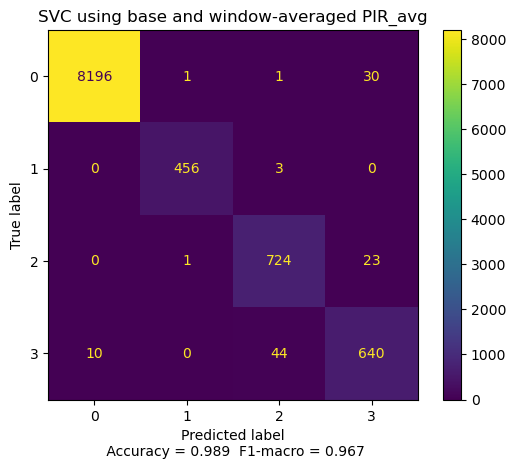

In [471]:
svc_predictions_2 = cross_val_predict(std_svc_best_2,X_avg_PIR,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,svc_predictions_2,'SVC using base and window-averaged PIR_avg')

It looks like adding the window-averaged `avg_PIR` increased model's prediction slightly, from 0.986 to 0.989 in accuracy and 0.959 to 0.967 in macro f1 score.

### Base with the two window-averaged PIR signals.

Let's see if applying the averaging window of two PIR sensors signals improves the prediction.

In [473]:
svc_pipeline_3 = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average(25),['S6_PIR','S7_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC(C=10, gamma=0.01))
])

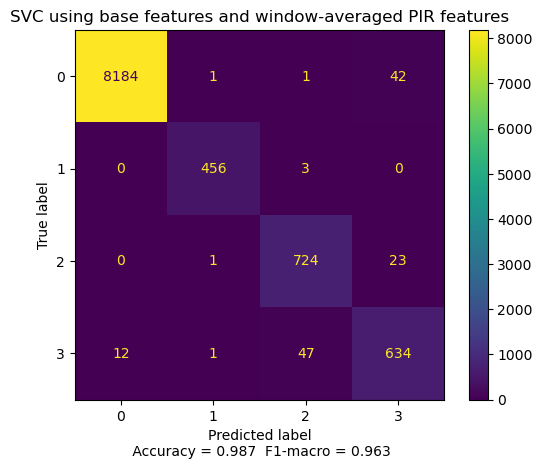

In [474]:
svc_predictions_3 = cross_val_predict(svc_pipeline_3,X_base,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,svc_predictions_3,'SVC using base features and window-averaged PIR features')

The model performs better than with the base features, but not as good as with the window_averaged `avg_PIR` feature.

## Models

### KNN

In [170]:
knn_pipeline = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average(25),['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# knn_param_grid = [{
#     'knn__n_neighbors':[1,2,3,4,5,6,7,10,50],
#     'knn__weights' : ['uniform', 'distance'],
#     'knn__p':[1,2]
# }]

knn_param_grid = [{
    'knn__n_neighbors':[3],
    'knn__weights' : ['uniform'],
    'knn__p':[2]
}]

knn_grid = GridSearchCV(knn_pipeline,knn_param_grid,scoring='f1_macro',cv=10,n_jobs=-1)
knn_grid.fit(X_avg_PIR,y)
std_knn_best_1 = knn_grid.best_estimator_
std_knn_best_1

Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [171]:
knn_grid.best_params_

{'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'uniform'}

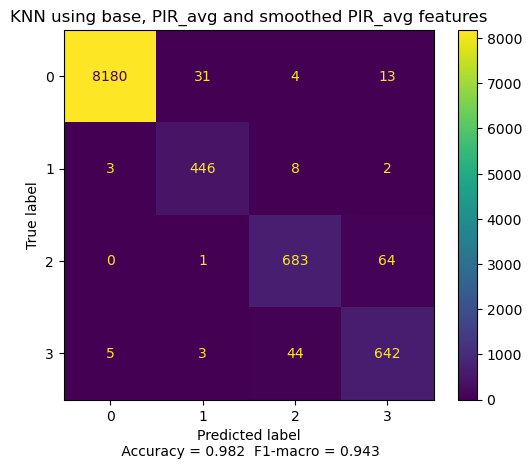

In [174]:
knn_predictions = cross_val_predict(std_knn_best_1,X_avg_PIR,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,knn_predictions,'KNN using base, PIR_avg and smoothed PIR_avg features')

### Random Forest

In [175]:
rf_pipeline = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average(25),['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])


# rf_random_grid = {'rfc__bootstrap': [True, False],
#                'rfc__max_depth': [5,10, 20,50, 100, None],
#                'rfc__max_features': [1.0, 'sqrt'],
#                'rfc__min_samples_leaf': [ 2, 4,8],
#                'rfc__min_samples_split': [2, 5, 10],
#                'rfc__n_estimators': [100, 200, 500,1000]}

rf_random_grid = {'rfc__bootstrap': [True],
               'rfc__max_depth': [None],
               'rfc__max_features': ['sqrt'],
               'rfc__min_samples_leaf': [ 8],
               'rfc__min_samples_split': [5],
               'rfc__n_estimators': [100]}

#grid = GridSearchCV(pipeline,param_grid,scoring='f1_macro',cv=10,n_jobs=-1)
rf_grid = RandomizedSearchCV(rf_pipeline, rf_random_grid, n_iter = 200, cv = 10, n_jobs = -1,verbose=1)
rf_grid.fit(X_avg_PIR,y)
std_rf_best = rf_grid.best_estimator_
std_rf_best

/Users/clement/miniconda3/envs/DataScience/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(min_samples_leaf=8,
                                        min_samples_split=5))])

In [176]:
rf_grid.best_params_

{'rfc__n_estimators': 100,
 'rfc__min_samples_split': 5,
 'rfc__min_samples_leaf': 8,
 'rfc__max_features': 'sqrt',
 'rfc__max_depth': None,
 'rfc__bootstrap': True}

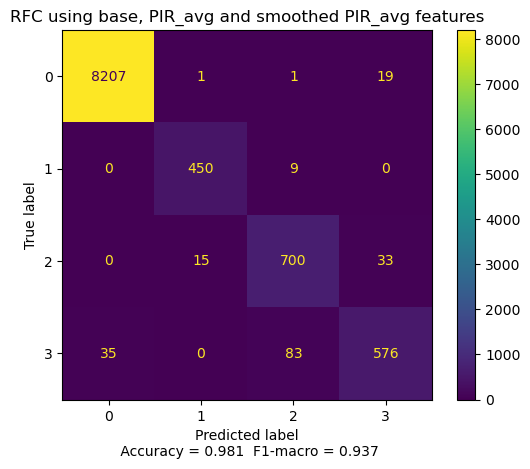

In [177]:
rf_predictions = cross_val_predict(std_rf_best,X_avg_PIR,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,rf_predictions,'RFC using base, PIR_avg and smoothed PIR_avg features')

### XGBoost model

In [178]:
xgb_pipeline= Pipeline([
    ('averager',ColumnTransformer([
        ('w_PIR',Window_Average(25),PIR_features)],
        remainder='passthrough')),
   ('scaler', StandardScaler()),
   ('xgb', XGBClassifier(objective = 'multi:softmax',num_class=4))
   ])

In [182]:
# xgb_params_grid = { 
#     'xgb__max_depth': [3, 4, 5],
#     'xgb__learning_rate': [0.001, 0.01, 0.1, ],
#     # "xgb__gamma":[0, 0.25, 0.5, 0.75,1],
#     'xgb__n_estimators': [100, 500, 1000],
#     # "xgb__subsample":[0.9],
#     # "xgb__colsample_bytree":[0.5],
#     # "xgb__early_stopping_rounds": [10], 
# }

xgb_params_grid = { 
    'xgb__max_depth': [3],
    'xgb__learning_rate': [0.1],
    'xgb__n_estimators': [1000],
}

xgb_grid = GridSearchCV(
    estimator = xgb_pipeline,
    param_grid = xgb_params_grid,
    scoring = 'f1_macro',
    n_jobs = -1,
    cv = 10,
    verbose = 1,
)

# Model fitting
xgb_grid_fit = xgb_grid.fit(X_avg_PIR,y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [183]:
xgb_grid_fit.best_params_

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 1000}

In [184]:
std_xgb_best = xgb_grid_fit.best_estimator_

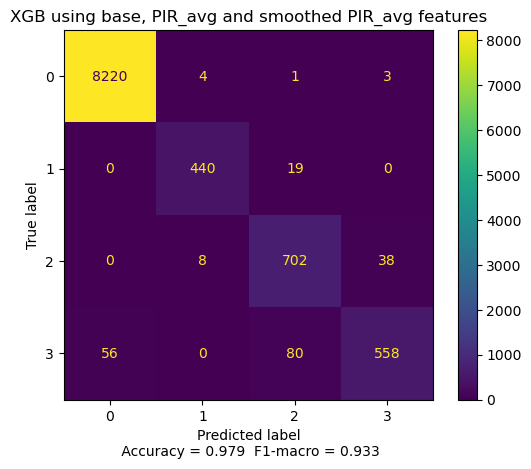

In [185]:
xgb_predictions = cross_val_predict(std_xgb_best,X_avg_PIR,y,cv=10)
plot_confusion_acc_f1(y,xgb_predictions,'XGB using base, PIR_avg and smoothed PIR_avg features')

### LGBM

In [162]:
lgbm_pipeline= Pipeline([
    ('averager',ColumnTransformer([
        ('w_PIR',Window_Average(25),PIR_features)],
        remainder='passthrough')),
   ('scaler', StandardScaler()),
   ('lgbm', LGBMClassifier())
   ])

# lgbm_param_grid =  {
#     'lgbm__num_leaves': [31,100],
#     'lgbm__max_depth': [-1,5],
#     'lgbm__learning_rate' : [0.1,0.05],
#     'lgbm__n_estimators': [100,50]
#     }

lgbm_param_grid =  {
    'lgbm__num_leaves': [31],
    'lgbm__max_depth': [5],
    'lgbm__learning_rate' : [0.05],
    'lgbm__n_estimators': [100]
    }

In [163]:
lgbm_grid = GridSearchCV(
    estimator = lgbm_pipeline,
    param_grid = lgbm_param_grid,
    scoring = 'f1_macro',
    n_jobs = -1,
    cv = 10,
    verbose = 0,
)
lgbm_grid_fit = lgbm_grid.fit(X_avg_PIR,y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [164]:
print(lgbm_grid_fit.best_params_)

{'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31}


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 17
[LightGBM] [Info] Start training from score -0.207741
[LightGBM] [Info] Start training from score -3.094339
[LightGBM] [Info] Start training from score -2.606041
[LightGBM] [Info] Start training from score -2.681636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

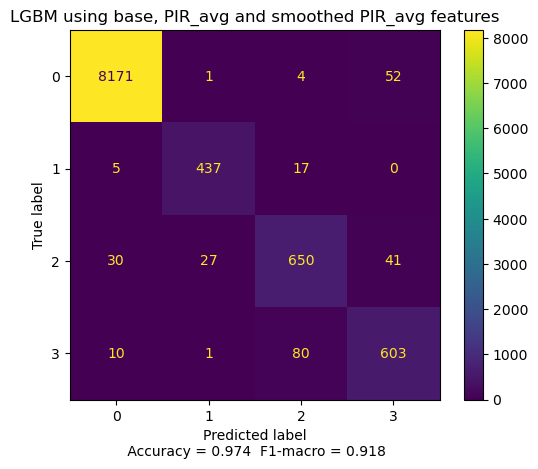

In [165]:
lgbm_predictions = cross_val_predict(std_lgbm_best,X_avg_PIR,y,cv=10)
plot_confusion_acc_f1(y,lgbm_predictions,'LGBM using base, PIR_avg and smoothed PIR_avg features')

### LDA

In [189]:
lda_pipeline= Pipeline([
    ('averager',ColumnTransformer([
        ('w_PIR',Window_Average(25),PIR_features)],
        remainder='passthrough')),
   ('scaler', StandardScaler()),

   ('lda', LinearDiscriminantAnalysis())
   ])


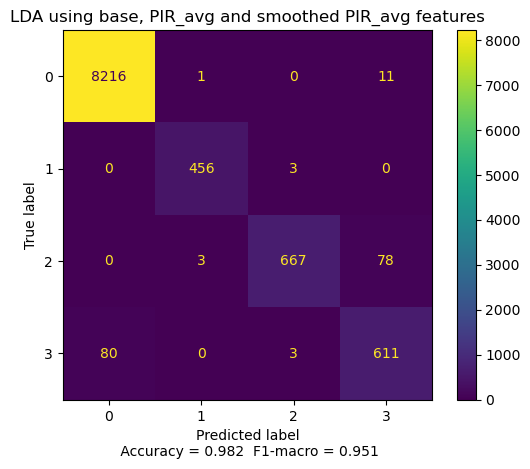

In [190]:
lda_predictions = cross_val_predict(lda_pipeline,X_avg_PIR,y,cv=10)
plot_confusion_acc_f1(y,lda_predictions,'LDA using base, PIR_avg and smoothed PIR_avg features')

No other model outperformed the SVC classifier in terms of both accuracy and F1-score. We will see if combining all of them leads to improved performance.

## Voting classifier using best results

In [198]:
vc = VotingClassifier([('SVC',std_svc_best_3),('knn',std_knn_best_1),('rff',std_rf_best),('xgb',std_xgb_best),('lgbm',std_lgbm_best),('lda',lda_pipeline)],voting='hard')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 17
[LightGBM] [Info] Start training from score -0.207876
[LightGBM] [Info] Start training from score -3.094339
[LightGBM] [Info] Start training from score -2.606041
[LightGBM] [Info] Start training from score -2.680035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

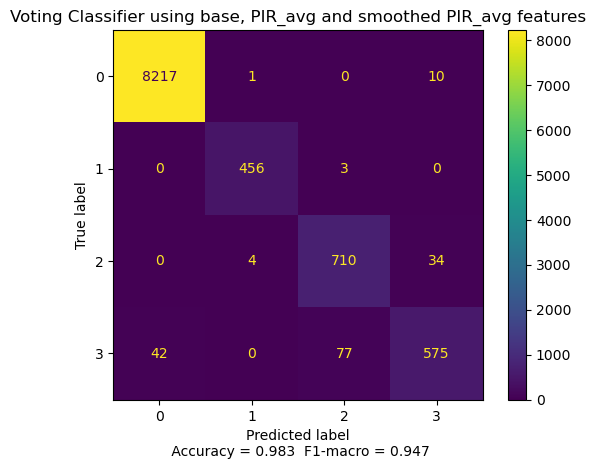

In [199]:
predictions = cross_val_predict(vc,X_avg_PIR,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,predictions,'Voting Classifier using base, PIR_avg and smoothed PIR_avg features')

## Conclusion

Overall, it looks like the only improvement came from improve feature engineering, in particular adding a average PIR columns an avereaging it over time. The best beforming model we found is the same as used in the paper, SVC with rbf kernel.

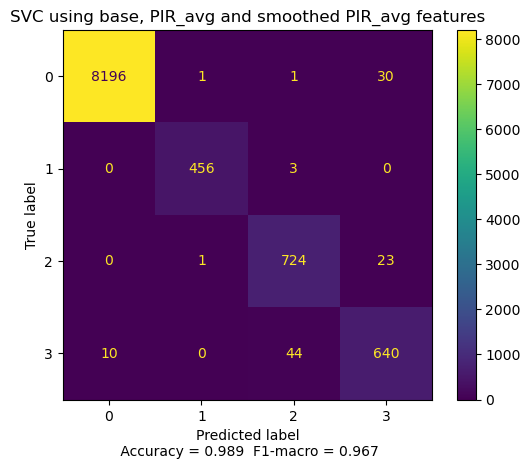

In [201]:
plot_confusion_acc_f1(y,svc_predictions_3,'SVC using base, PIR_avg and smoothed PIR_avg features')